<a href="https://www.kaggle.com/code/kousei74/chordsclasifier?scriptVersionId=155585440" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# INTRODUCTION


**Problem Statement:** To classify chords from a dataset of pre-labelled chords audio file dataset, into "Major" and "Minor" chords. As we are aiming for classification, the dataset with predefined chords type is most suitable.

**Dataset used: **
[Musical Instrument chords classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification)



# Pre-Requisites


Before we start, we need to know a few things.

In music, we have **notes** as its smallest building blocks, just like cells in a living organism. In the west, it is divided into 7 natural notes - 

**A(A#) B C(C#) D(D#) E F(F#) G(G#)**

Except for two notes, as we can see above, all the other 5 notes have a sharp(#) note associated to it. This is an exception we need to keep in mind.

*Other Important Facts: *
* All the frequency intervals between each note is equal in logarithmic scale
* The note **A** has a frequency of 440Hz (to be used as a reference point)
* If we double the frequency of a note, we get the same note one octave higher.


*For eg., if we take 440Hz as the frequency of **A**, then we get **A** at 220Hz, 880Hz, 1760Hz ..... and so on. Note that we get **A** only by doubling the frequency of the previous note, and not from multiples of the inital 440Hz.*

Since we have 12 notes (including all the sharps), we can get the frequency of the next note by multiplying the frequency of the previous note by 2^(1/2). *For eg., We can get **A#** from **A** by multiplying (440 * 2^(1/12))Hz, if we do it again, it will give us (440 * 2^(2/12))Hz, which is **B**, and so on.*

Now, the last thing we need to coverup is **Chords**.
Chords consists of sets of 3 or more notes, or frequencies in this case. To classify the chords into major or minor, we need to find the frequencies of each note being played.
Rest of the information will be explained as we move further.

Since we covered up the pre-requisites, let's get started with the model.

In [1]:
import os
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import spectrogram, find_peaks
from scipy.io import wavfile
from scipy.fft import fft, fftfreq


The first thing we need to do here is create a dataframe containing the frequencies of each notes in the hearing range of humans *(20Hz - 20kHz)*. So I'm starting out with A as the first note, which gives us 55Hz as the first frequency within the considered range.

To calculate the frequency of remaining 96 notes *(8 octaves - each octave has 12 notes)* , I'll run a for loop for 96 times.

In [2]:
curr_freq = 55
freq_list = []

for i in range(96): 
    freq_list.append(curr_freq)
    curr_freq *= np.power(2, 1/12) 

#reshaping and creating dataframe
freq_array = np.reshape(np.round(freq_list,1), (8, 12))
cols = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
df_note_freqs = pd.DataFrame(freq_array, columns=cols)
print("NOTE FREQUENCIES IN WESTERN MUSIC")
df_note_freqs.head(10)

NOTE FREQUENCIES IN WESTERN MUSIC


,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
0,55.0,58.3,61.7,65.4,69.3,73.4,77.8,82.4,87.3,92.5,98.0,103.8
1,110.0,116.5,123.5,130.8,138.6,146.8,155.6,164.8,174.6,185.0,196.0,207.7
2,220.0,233.1,246.9,261.6,277.2,293.7,311.1,329.6,349.2,370.0,392.0,415.3
3,440.0,466.2,493.9,523.3,554.4,587.3,622.3,659.3,698.5,740.0,784.0,830.6
4,880.0,932.3,987.8,1046.5,1108.7,1174.7,1244.5,1318.5,1396.9,1480.0,1568.0,1661.2
5,1760.0,1864.7,1975.5,2093.0,2217.5,2349.3,2489.0,2637.0,2793.8,2960.0,3136.0,3322.4
6,3520.0,3729.3,3951.1,4186.0,4434.9,4698.6,4978.0,5274.0,5587.7,5919.9,6271.9,6644.9
7,7040.0,7458.6,7902.1,8372.0,8869.8,9397.3,9956.1,10548.1,11175.3,11839.8,12543.9,13289.8


# Formation
To proceed further, we need to know how the **Major** and **Minor** chords are formed.

***Whole step** - moving two consequtive notes (Represented as 1 step)
**Half step** - moving one consequtive note (Represented by 0.5 step)*


Forming a **major** chord, we need to select a root note of which we need to make the major chord, then we need to move **2 whole steps** to find the 2nd note, and **1.5 steps** more to find the 3rd note. 

Similarly, for a minor chord, we need to select a root note of which we need to make the minor chord, then we need to move 2 whole steps to find the 2nd note, and 1.5 steps more to find the 3rd note.


*For eg, let's take **A** as our root note. For **A major**, 2nd note will be **C#** (A -> A# -> B -> C -> C#) and the 3rd note will be **E** (C# -> D -> D# -> E). Similarly, for **A minor**, 2nd note will be **C** (A -> A# -> B -> C) and the 3rd note will be **E** (c -> C# -> D -> D# -> E). 
Note that, we count the jumps or steps taen, not the number of notes we covered.*


The dataset contains different Major and Minor chord recordings in *.wav* format, which we can display and hear in the notebook using the IPhython package.

In [3]:
path_1 = "../input/musical-instrument-chord-classification/Audio_Files/Major/Major_0.wav"

IPython.display.Audio(path_1, rate = 44100)

In [4]:
path_2 = "../input/musical-instrument-chord-classification/Audio_Files/Minor/Minor_0.wav"

IPython.display.Audio(path_2, rate = 44100)

# Domain Representation

To analyse our recordings, we need to transform the audio files into a dataset on which we can further work upon. This is where Fourier Transform comes in - it converts the audio files into frequency-domain representation, from where we will get our required data. Wav files are Major and Minor chords that contain at least three notes or more. So we can expect a complex plot, like the plots of the notes are overlapped.Intervals between harmonics will not be equal. This is great because I am planning to build my classification model on the relationship of harmonics.

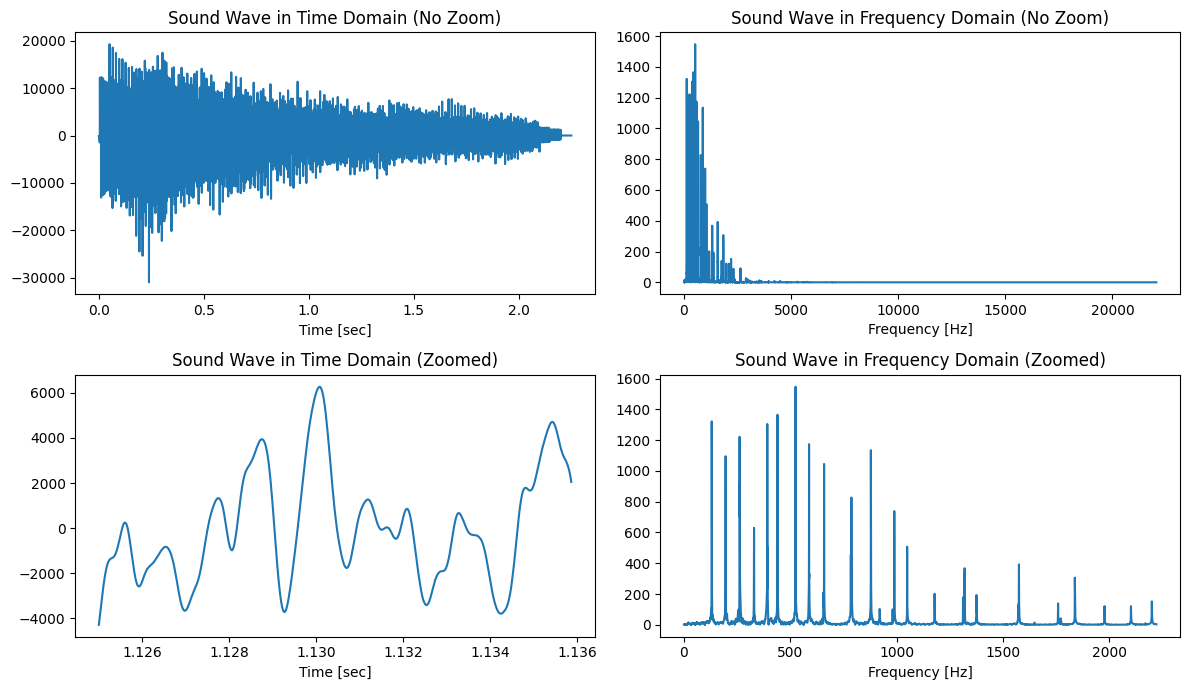

In [5]:
path = "../input/musical-instrument-chord-classification/Audio_Files/Major/Major_2.wav"
fs, signal = wavfile.read(path)
N = len(signal)
time = np.linspace(0., N/fs, N)

# Fourier Transform
y_freq = fftfreq(N, 1/fs)[:N//2]  # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0,0].plot(time, signal)
axes[0,0].set_title("Sound Wave in Time Domain (No Zoom)")
axes[0,0].set(xlabel='Time [sec]')
axes[0,1].plot(y_freq, signal_f_onesided)
axes[0,1].set_title("Sound Wave in Frequency Domain (No Zoom)")
axes[0,1].set(xlabel='Frequency [Hz]')
axes[1,0].plot(time[(N//2):(N//2+480)], signal[(N//2):(N//2+480)])
axes[1,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[1,0].set(xlabel='Time [sec]')
axes[1,1].plot(y_freq[:5000], signal_f_onesided[:5000])
axes[1,1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1,1].set(xlabel='Frequency [Hz]')
fig.tight_layout()
plt.show()

**Spectogram**

In the previous section, we have seen the time and frequency plots of a sound wave. Now, I also want to plot the spectrogram of the signal. A spectrogram is a powerful way to visualize a signal over time at various frequencies. It is calculated by splitting the signal into small pieces in time and later applying Fourier transform. As a result, a 2D matrix is obtained and can be plotted. Good news: Scipy has a method for spectrogram, so we don't have to do calculations from the scratch. Documentation of the spectrogram method can be found here.

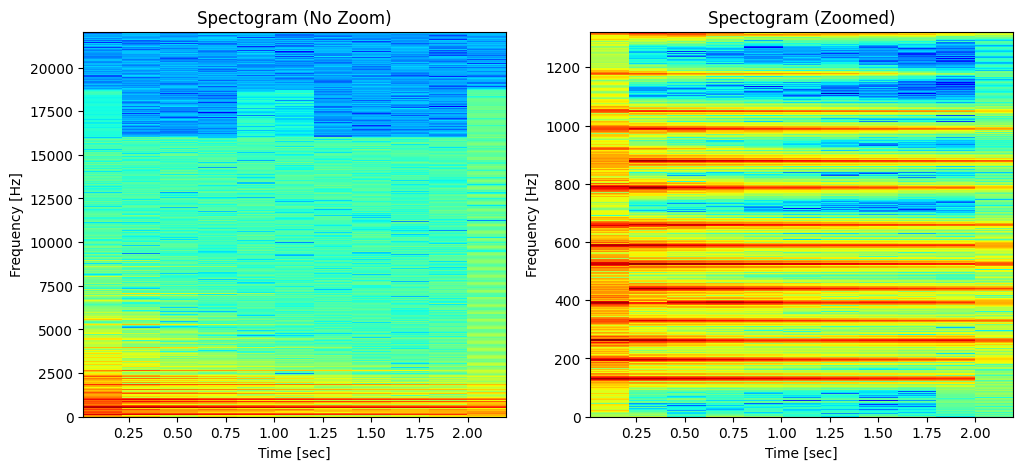

In [6]:
# applying spectrogram
f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft = 50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t, f, np.log(Sxx), cmap="jet")
axes[0].set_title("Spectogram (No Zoom)")
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap="jet")
axes[1].set_title("Spectogram (Zoomed)")
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
plt.show()

# Detection of Harmonic Frequencies

So as of now, we can read a wav file and save it in an array that is in the time domain. We can also obtain an array in the frequency domain by applying the Fourier transform. Also, Spectrogram is applied to obtain a 2D matrix that has both time and frequency information. 

The time-domain array is not suitable to use in this project. I will not use the Spectrogram matrix too, because our recordings contain only one chord, so frequency information doesn't change with time. For example, if we had a recording that changes chords every second, we would see in the visualization that harmonics are changing every second.

In this project, I will continue with the frequency array. There are peak values in the frequency plot which are harmonics. I believe that if I can find at which frequencies peaks occur, I can use that data to build a model. To do this, I will use find_peaks method from Scipy which returns the indices of peaks. When I plug these indices into the frequency stamp array, I will obtain harmonic frequencies.

If we see closely in the frequency-domain representaion, the peaks and the graphs represent the notes frequencies. There are some smaller spikes too, like a spike of 2Hz, but we won't consider them. These smaller spikes are more likely to be noise. So I will ignrore the spikes which are smaller than 50Hz.

To find the peaks, the *find_peaks* method is used from *Scipy*, which gives us the peak values. When these indices are plugged into the frequency stamp array, we will get the **harmonic frequencies**.

Harmonics: [ 131.  196.  257.  262.  330.  392.  440.  520.  525.  588.  659.  788.
  879.  920.  981.  989. 1050. 1179. 1312. 1320. 1376. 1576. 1760. 1838.
 1978. 2102. 2200. 2308. 2640.]


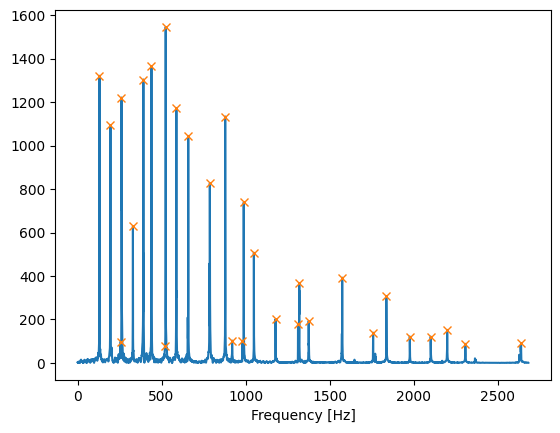

In [7]:
# h: height threshold. I defined as %5 of max value
h = signal_f_onesided.max()*5/100
peaks, _ = find_peaks(signal_f_onesided, distance=10, height = h)

freq_50_index = np.abs(y_freq - 50).argmin() # finding index for 50 Hz
peaks = peaks[peaks>freq_50_index] # filtering peaks less than 50 Hz
harmonics = y_freq[peaks]
print("Harmonics: {}".format(np.round(harmonics)))

# Plot
i = peaks.max() + 100
plt.plot(y_freq[:i], signal_f_onesided[:i])
plt.plot(y_freq[peaks], signal_f_onesided[peaks], "x")
plt.xlabel('Frequency [Hz]')
plt.show()

Surprisingly everything is working fine till now. Lol.

So let's now make a method which can be used in the later sections.
The method will take an audio file as input, apply Fourier, and find and return the peak frequencies.

In [8]:
def find_harmonics(path, print_peaks=False):
    fs, K = wavfile.read(path)
    N = len(K)
    K_F = fft(K)
    K_F_onesided = 2.0/N * np.abs(K_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = K_F_onesided.max()*5/100
    peaks, _ = find_peaks(K_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], K_F_onesided[:i])
        plt.plot(freqs[peaks], K_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

Now, to check if the function is actually working...

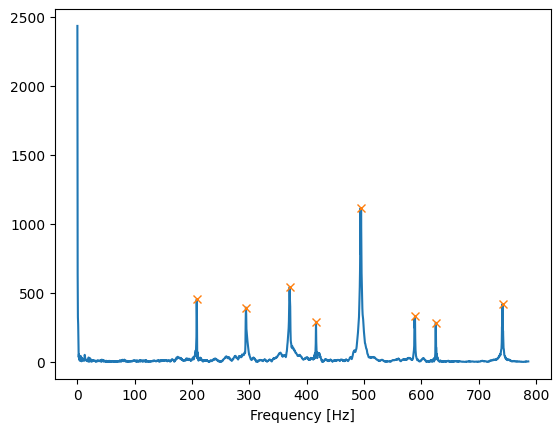

Harmonics: [208. 294. 370. 416. 494. 589. 625. 742.]


In [9]:
path = "../input/musical-instrument-chord-classification/Audio_Files/Minor/Minor_169.wav"

harmonics_2 = find_harmonics(path, print_peaks=True)
print("Harmonics: {}".format(np.round(harmonics_2)))

# Creating DataFrame

So till now, we got to know how to find the harmonic frequencies from a single audio file. Now, we need to save all the harmonic freqiencies, chord type, and number of harmonics of all the audio files from the initial dataset and create a seperate dataframe to work upon.

In [10]:
path = "/kaggle/input/musical-instrument-chord-classification/Audio_Files"

data = []
max_harm_length = 0 # for track of max harmonic length to name columns

for dirn, _, files in os.walk(path):
    for file in files:
        folder = os.path.basename(dirn)
        full_path = os.path.join(dirn, file)
        freq_peaks = find_harmonics(full_path)
        
        max_harm_length = max(max_harm_length, len(freq_peaks))
        
        cur_data = [folder, file]
        cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        cur_data.extend(freq_peaks)
        
        data.append(cur_data)
        


In [11]:
# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()


,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_337.wav,83.04,993.49,18,83.04,130.87,165.22,196.52,247.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_19.wav,278.18,1052.73,8,278.18,350.45,467.27,556.36,624.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_444.wav,104.35,1873.93,27,104.35,155.22,209.13,262.18,311.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_380.wav,138.67,2449.33,28,138.67,155.56,208.44,262.22,277.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_368.wav,138.67,2492.44,27,138.67,208.89,247.11,277.78,349.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df["Chord Type"].value_counts()

Chord Type
Major    502
Minor    357
Name: count, dtype: int64

# Some more Pre-Processing

The column **# of Harmonics** gives us the number of harmonic values that are not null in that row. 

In [13]:
df_original = df.copy() #saving a copy incase I mess up the original one, or if I need :)

In [14]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

From the output, we can figure out that:
* Every row contains atleast 8 harmonics
* Max no. of harmonics is 38
* Harmonic 9 is the first column with null values
* Since harmonics are ordered, missing values increase as the harmonic number
* The mean value of number of harmonics is 20

From the above observations, we see that the first 8 harmonics are absolutely important. Harmonics bigger than 20 are not that important, so we won't consider them.

# Harmonics

Here we plot the distributions of Min and Max Harmonics by setting hue as "Chord Type". 

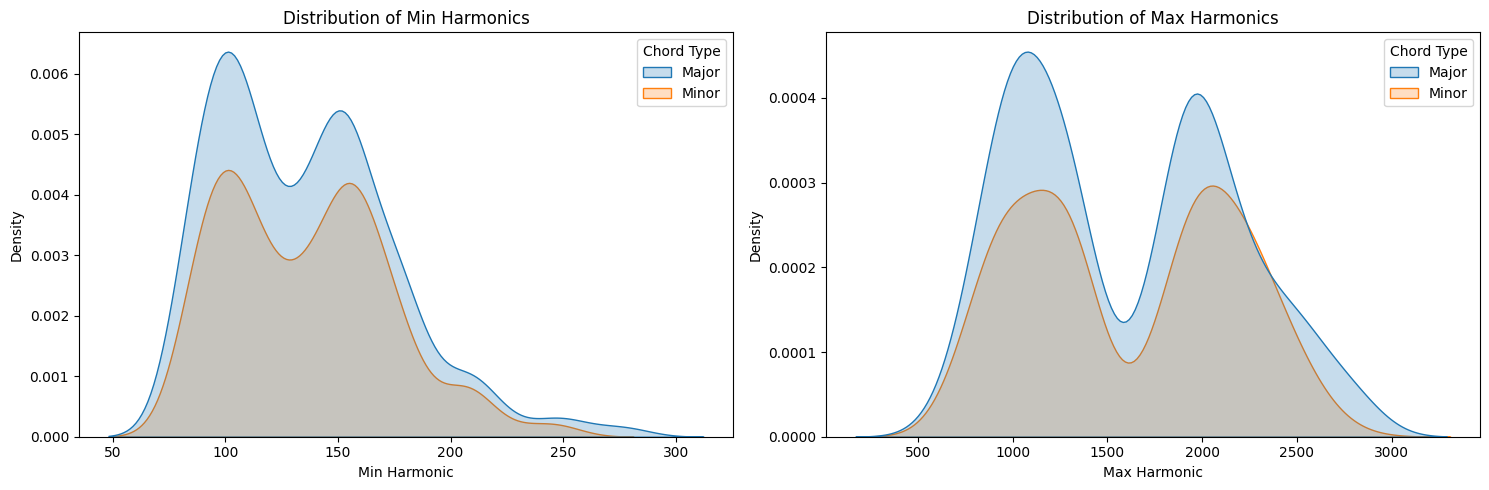

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(ax=axes[0], data=df, x="Min Harmonic", hue="Chord Type", fill=True)
sns.kdeplot(ax=axes[1], data=df, x="Max Harmonic", hue="Chord Type", fill=True)
axes[0].set_title("Distribution of Min Harmonics")
axes[1].set_title("Distribution of Max Harmonics")
fig.tight_layout()
plt.show()

As expected, the min harmonics distribution for major and minor chords are extremely close. This is because min harmonics determines the note of the chord. 

*For eg., at 440Hz we get either "A Major" or "A Minor". *

And if you are wondering about the max harmonics distribution, don't worry it's just useless :)

We can't determine what chord it is just by it's root note (*first note is also called as root note*). The intervals between the harmonics make the difference between the major and minor chords.

To obtain the first interval, we need to divide Harmonic2 with Harmonic1.

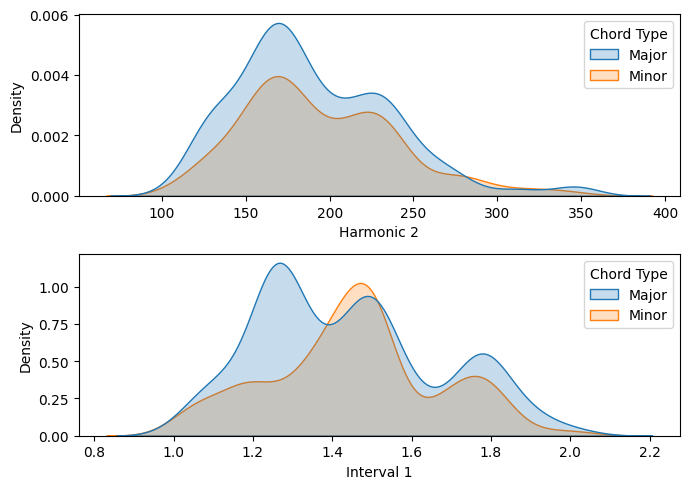

In [16]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic 2", hue="Chord Type", fill=True)
sns.kdeplot(ax=axes[1], data=df, x="Interval 1", hue="Chord Type", fill=True)
fig.tight_layout()
plt.show()

Now, we have the data that changes with chord type.
Rest of the intervals will be calculated wuth a loop, which will run for 20 times since only the first 20 harmonics are considered. The ratio of the current harmonic to the previous one will be calculated for each interval.

In [17]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_337.wav,83.04,993.49,18,83.04,130.87,165.22,196.52,247.83,...,1.056099,1.105398,1.018769,1.111269,1.008617,1.389878,1.080891,NaN,NaN,NaN
1,Major,Major_19.wav,278.18,1052.73,8,278.18,350.45,467.27,556.36,624.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_444.wav,104.35,1873.93,27,104.35,155.22,209.13,262.18,311.31,...,1.234308,1.011172,1.054115,1.005241,1.122453,1.114209,1.005836,1.039768,1.142625,1.004884
3,Major,Major_380.wav,138.67,2449.33,28,138.67,155.56,208.44,262.22,277.78,...,1.117986,1.113802,1.011417,1.059246,1.120939,1.115494,1.006394,1.039370,1.143789,1.003918
4,Major,Major_368.wav,138.67,2492.44,27,138.67,208.89,247.11,277.78,349.78,...,1.006432,1.184032,1.054360,1.006394,1.178237,1.008263,1.004635,1.116706,1.045743,1.014579


So now we have all the interval data in out dataframe. Let's plot all of them and see which ones to consider. 

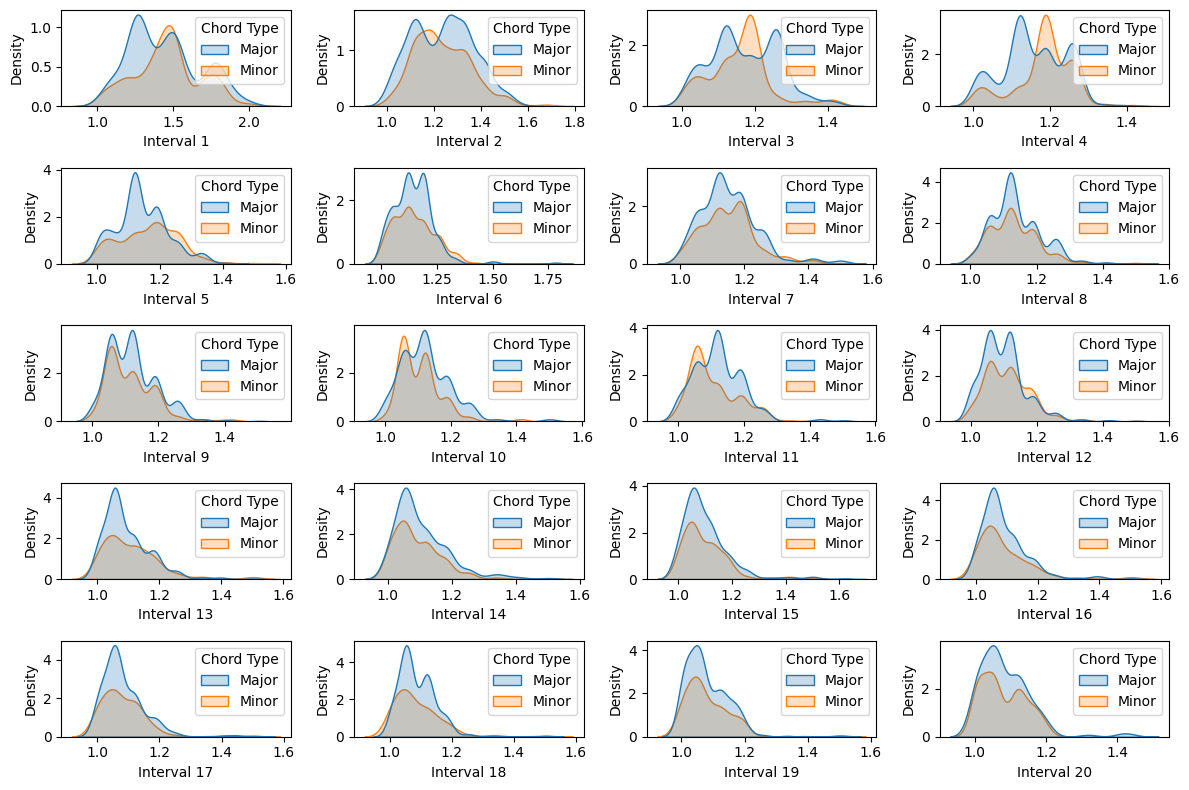

In [18]:
# Lets plot them
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", fill=True)
fig.tight_layout()
plt.show()

Conslusions:
* The first 4 intervals are the most important
* Loses it's importance after Interval 13
* Since we encounter null values starting from interval 8 , we are going to drop all of them.


So we analysed the intervals between consequtive harmonics. Now comes total interval until a specific harmonic. Basically it's the interval between the first harmonic and any other harmonic (doesn't have to be consequtive). So, looping again...

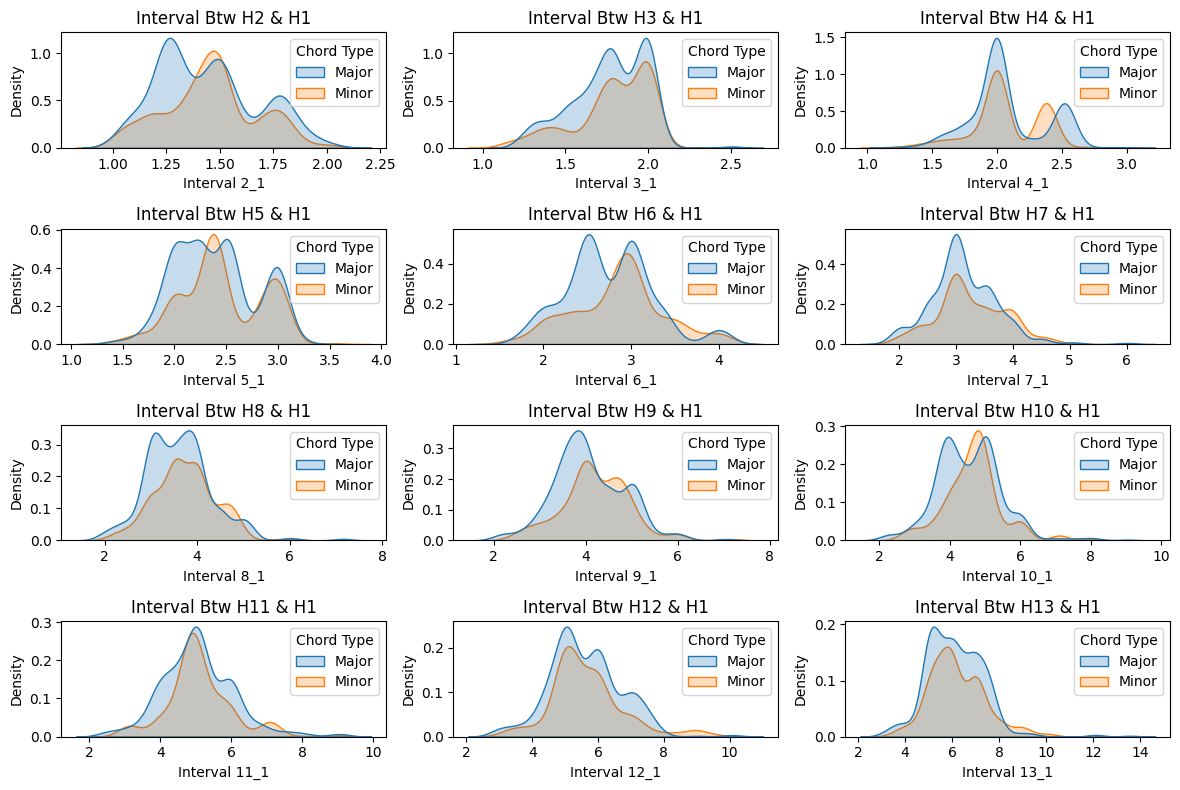

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", fill=True)
fig.tight_layout()
plt.show()

**Conlusion:**
The interval between **H2-H1** is important but it's basically the *Interval 1* which was previously calculated. The interval between **H3-H1** isn't that relevant as there as Minor lies completely under the major curve, but the next 4 plots are perfect for interval analysis.

So finally, the interval plots we'd be considering in the model are:
* Interval 1
* Interval 2
* Interval 3
* Interval 4
* Interval 4_1
* Interval 5_1
* Interval 6_1


The last step left before us is changing the column "Chord Type". Since it consists of only two strings - **Major** and **Minor**, we can assign **Major**=1 and **Minor**=0.

In [20]:
df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)

df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 4_1,Interval 5_1,Interval 6_1,Interval 7_1,Interval 8_1,Interval 9_1,Interval 10_1,Interval 11_1,Interval 12_1,Interval 13_1
0,1,Major_337.wav,83.04,993.49,18,83.04,130.87,165.22,196.52,247.83,...,2.366570,2.984465,3.151975,3.204359,3.989764,4.727962,4.968810,5.974109,6.309249,6.974229
1,1,Major_19.wav,278.18,1052.73,8,278.18,350.45,467.27,556.36,624.09,...,2.000000,2.243475,3.003271,3.361133,3.784348,NaN,NaN,NaN,NaN,NaN
2,1,Major_444.wav,104.35,1873.93,27,104.35,155.22,209.13,262.18,311.31,...,2.512506,2.983325,3.979109,4.033253,4.474940,5.029133,5.979109,6.045807,7.462386,7.545759
3,1,Major_380.wav,138.67,2449.33,28,138.67,155.56,208.44,262.22,277.78,...,1.890964,2.003173,2.243528,2.522391,3.006346,3.365328,3.785173,4.509483,5.041537,5.615274
4,1,Major_368.wav,138.67,2492.44,27,138.67,208.89,247.11,277.78,349.78,...,2.003173,2.522391,2.993510,3.567246,4.509483,5.041537,5.349246,5.987020,6.025528,7.134420


And with this, we can finally enter the model building phase T_T.

# Model Building

For the model training part, we are choosing Decision Tree and Random forest

In [21]:
# importing packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Final pre-processing

In [22]:
columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4", "Interval 5"]
columns.extend(["Interval 2_1","Interval 4_1", "Interval 5_1", "Interval 6_1"])
train_X, val_X, train_y, val_y = train_test_split(df[columns], df["Chord Type"], test_size=0.40, random_state=42)
train_X.head()



,Interval 1,Interval 2,Interval 3,Interval 4,Interval 5,Interval 2_1,Interval 4_1,Interval 5_1,Interval 6_1
526,1.498471,1.120985,1.125895,1.055927,1.258697,1.498471,1.891238,1.997009,2.513629
531,1.193379,1.494530,1.123185,1.122745,1.059746,1.193379,2.003246,2.249134,2.383511
94,1.504945,1.189348,1.114552,1.270694,1.187353,1.504945,1.994940,2.534959,3.009890
11,1.254769,1.336333,1.192755,1.121653,1.118641,1.254769,2.000000,2.243306,2.509453
398,1.506382,1.329791,1.259198,1.186775,1.340464,1.506382,2.522391,2.993510,4.012692


In [23]:
print("The shape of X_train is      ", train_X.shape)
print("The shape of X_test is       ", val_X.shape)
print("The shape of y_train is      ", train_y.shape)
print("The shape of y_test is       ", val_y.shape)

The shape of X_train is       (515, 9)
The shape of X_test is        (344, 9)
The shape of y_train is       (515,)
The shape of y_test is        (344,)


Checking cross-val score for model selection

In [24]:
lr = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
svc = SVC(random_state=0)
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

score_lr = cross_val_score(lr, train_X, train_y, cv=10).mean()
score_knn = cross_val_score(knn, train_X, train_y, cv=10).mean()
score_svc = cross_val_score(svc, train_X, train_y, cv=10).mean()
score_gnb = cross_val_score(gnb, train_X, train_y, cv=10).mean()
score_dtc = cross_val_score(dtc, train_X, train_y, cv=10).mean()
score_rfc = cross_val_score(rfc, train_X, train_y, cv=10).mean()

print("Cross Val Score for Logistic Regression: {:.2f}".format(score_lr))
print("Cross Val Score for KNeighbors Classifier: {:.2f}".format(score_knn))
print("Cross Val Score for SVC: {:.2f}".format(score_svc))
print("Cross Val Score for Gaussian NB: {:.2f}".format(score_gnb))
print("Cross Val Score for Decision Tree Classifier: {:.2f}".format(score_dtc))
print("Cross Val Score for Random Forest Classifier: {:.2f}".format(score_rfc))

Cross Val Score for Logistic Regression: 0.59
Cross Val Score for KNeighbors Classifier: 0.81
Cross Val Score for SVC: 0.57
Cross Val Score for Gaussian NB: 0.60
Cross Val Score for Decision Tree Classifier: 0.91
Cross Val Score for Random Forest Classifier: 0.91


So we will proceed with Decision Tree and Random Forest Classifier as they have the highest cross-val score.

In [25]:
classifier1 = RandomForestClassifier(random_state=0)

classifier1.fit(train_X, train_y) 
pred_yr = classifier1.predict(val_X)

In [26]:
cmr = confusion_matrix(val_y, pred_yr)
accr = accuracy_score(val_y, pred_yr)

print("Confusion Matrix of Random Forest:")
print(cmr)
print("Accuracy Score of Random Forest: {:.2f}".format(accr))

Confusion Matrix of Random Forest:
[[127   9]
 [ 15 193]]
Accuracy Score of Random Forest: 0.93


In [27]:
classifier2 = DecisionTreeClassifier(random_state=0)

classifier2.fit(train_X, train_y) 
pred_yd = classifier2.predict(val_X)

In [28]:
cmd = confusion_matrix(val_y, pred_yd)
accd = accuracy_score(val_y, pred_yd)

print("Confusion Matrix of Decision Tree:")
print(cmd)
print("Accuracy Score of Decision Tree: {:.2f}".format(accd))

Confusion Matrix of Decision Tree:
[[126  10]
 [ 19 189]]
Accuracy Score of Decision Tree: 0.92
